In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Modules for handling APIs
import requests
import json

import time
from sys import exit


# Module for choosing city nearest to random coordinates (in lat/lon)
from citipy import citipy

In [10]:
api_key = ""

In [11]:
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="

I wrote two custom functions to facilitate data retrieval from *OpenWeather*:

1. weather_batch()

2. multiple_batches()

***

**weather_batch()** retrieves a specified number of weather records from *OpenWeather*.

    parameters::
    city_count: the number of coordinates that will be used to find the nearest city
    your_url: the url with api_key, formatted for the API
    
    weather_batch() uses two helper functions:

    a. city_df_maker()
    b. weather_grabber()
    
    city_df_maker(): generates random lat/lon coordinates using 'numpy'. 
        * The number of random coordinates is based on the city_count argument from weather_batch().
        * It uses 'citipy' to retrieve the nearest city to each coordinate pair.
        * It returns a 'pandas' DataFrame object with lat, lon, and the corresponding name of the city.
    
    weather_grabber(): uses 'requests' to fetch the weather data from the API in json format.
        * It merges the weather data with the lat/lon data and returns a 'pandas' DataFrame object.
        

**multiple_batches()** uses weather_batch() to call multiple batches of weather data from the API.

    parameters::
    city_count_multiple: argument to be used for city_count from weather_batch(); max = 60/batch
    your_url_multiple: argument to be used for your_url in weather_batch())
    batches: the number of batches
    sleep_time: time delay between batches in seconds (via the 'time')

    To limit the number of calls/minute, the function calls exit from 'sys' if city_count_multiple is greater than 60.
    
    multiple_batches() returns a 'pandas' DataFrame of length city_count_multiple * batches.
    
    Duplicate cities are removed from the DataFrame based on the "city" column.

In [39]:
# Run this cell

# START
def weather_batch(city_count, your_url):
    
    print(f"Attempting to retrieve {city_count} records in this batch.\n")
    
    initial_count = city_count
    
    #--------------------#

    def city_df_maker(target_count):
    
        lat_range = np.arange(-90.00, 90.00, 0.01)
        lon_range = np.arange(-180.00, 180.00, 0.01)

        lats = np.random.choice(lat_range, target_count)
        lons = np.random.choice(lon_range, target_count)

        lat_lon_df = pd.DataFrame({"latitude" : lats, 
                                   "longitude" : lons})
 
        cities = [None] * len(lat_lon_df)

        for i in range(len(lat_lon_df)):
            cities[i] = citipy.nearest_city(lat_lon_df.iloc[i][0], lat_lon_df.iloc[i][1]).city_name.capitalize()

        lat_lon_df["city"] = cities    
        
        return lat_lon_df
    
    #--------------------#                                                              
    
    city_df_temp = city_df_maker(initial_count)
                                   
    #--------------------# 
    
    
    def weather_grabber(city_df, url_arg):
    
        city_df.set_index("city", inplace = True)
        city_list_temp = city_df.index.to_list()    
        
        max_temp = []
        humidity = []
        cloudiness = []
        wind_speed = []
        bad_cities = []
        country = []
        date = []
    
        for city_name in city_list_temp:
            response_temp = requests.get(url_arg + city_name)
            response_temp_json = response_temp.json()
    
            try:
                max_temp.append(response_temp_json["main"]["temp_max"])
                humidity.append(response_temp_json["main"]["humidity"])
                cloudiness.append(response_temp_json["clouds"]["all"])
                wind_speed.append(response_temp_json["wind"]["speed"])
                country.append(response_temp_json["sys"]["country"])
                date.append(response_temp_json["dt"])
                print(f"All temperature data for {city_name} found! Appending stats.")
        
            except Exception as e:
                print(f"Exception type: {e}")
                bad_cities.append(city_name)
                print(f"Temperature data for {city_name} was not found. Skipping this city.")
                pass
        
        for bad_city in bad_cities:
            city_list_temp.remove(bad_city)
        
        weather_df = pd.DataFrame({"city":city_list_temp, 
                                   "max_temp":max_temp, 
                                   "humidity":humidity,
                                   "cloud_cover":cloudiness, 
                                   "wind_speed":wind_speed, 
                                   "country":country,
                                   "date":date})
        
        weather_df["city"] = weather_df["city"].astype(str)
        
        city_df = city_df.drop(bad_cities)
        city_df = city_df.reset_index()
        city_df["city"] = city_df["city"].astype(str)
        
        weather_merged_df = pd.merge(city_df, weather_df, on = "city")
        
        return weather_merged_df   
    
    #--------------------# 

    weather_out_df = weather_grabber(city_df_temp, your_url)
    weather_out_df = weather_out_df.drop_duplicates(subset = "city", keep = "first")
    weather_out_df = weather_out_df.loc[weather_out_df["humidity"] <= 100]
    
    while len(weather_out_df) < initial_count:
        print("\n")
        print("Accounting for duplicate cities (or errant humidity measurements) within the batch.\n")
        new_city_df =  city_df_maker(initial_count - len(weather_out_df))
        weather_out_df_temp = weather_grabber(new_city_df, your_url)
        weather_out_df = pd.concat([weather_out_df, weather_out_df_temp])
        weather_out_df = weather_out_df.drop_duplicates(subset = "city", keep = "first")
        weather_out_df = weather_out_df.loc[weather_out_df["humidity"] <= 100]
    
    print(f"Success: returning DataFrame of length: {len(weather_out_df)}.")
    
    return weather_out_df.reset_index(drop = True)
# End


In [42]:
# Run this cell

# START
def multiple_batches(city_count_multiple, your_url_multiple, batches, sleep_time):
    
    if city_count_multiple > 60:
        print("The maximum number of calls/minute with your free API key is 60.")
        print("Call the function again with batches <= 60 to continue.")
        exit()
    
    records_goal = city_count_multiple * batches 
    
    print(f"Attempting to call a total of {records_goal} records, in batches of {batches}.")
    print(f"There will be a time delay of {sleep_time} seconds after each batch.\n")
              
    batch_list = []

    print("--------------------------------------------------")
    print("--------------------------------------------------\n")
    print("Batch 1.\n")
    batch_list.append(weather_batch(city_count_multiple, your_url_multiple))
    print("--------------------------------------------------\n")
    time.sleep(sleep_time) 
    
    for i in range(2, batches + 1):
        print(f"Batch {i}.\n")
        batch_list.append(weather_batch(city_count_multiple, your_url_multiple))
        print("--------------------------------------------------\n")
        time.sleep(sleep_time)
    
    output_df = pd.concat(batch_list)
    output_df.drop_duplicates(subset = "city", keep = "first", inplace = True)
    
    print("\n")
    print("--------------------------------------------------")
    print("--------------------------------------------------")
   
    while len(output_df) < records_goal:
        print("\n")
        print(f"There were some duplicate cities (or errant humidity measurements) when the batches were combined.")
        missing_record_count =  records_goal - len(output_df)
        print(f"Number of missing records after dropping duplicates: {missing_record_count}.\n")
        extra_temps_df = weather_batch(missing_record_count, your_url_multiple)
        output_df = pd.concat([output_df, extra_temps_df])
        output_df.drop_duplicates(subset = "city", keep = "first", inplace = True)
        output_df = output_df.loc[output_df["humidity"] <= 100]
    
    print("\n")
    print(f"Weather data for a total of {len(output_df)} cities have been retrieved.")
    print(f"Your query is complete!")
    
    return output_df.reset_index(drop = True)
# END


In [43]:
# Creating a DataFrame of length 500 (in 10 batches of 50, with a time delay of 61 seconds between batches)
weather_batch_all = multiple_batches(50, query_url, 10, 61)

Attempting to call a total of 500 records, in batches of 10.
There will be a time delay of 61 seconds after each batch.

--------------------------------------------------
--------------------------------------------------

Batch 1.

Attempting to retrieve 50 records in this batch.

Exception type: 'main'
Temperature data for Mys shmidta was not found. Skipping this city.
All temperature data for Samarai found! Appending stats.
All temperature data for Sorland found! Appending stats.
All temperature data for Touros found! Appending stats.
All temperature data for Kysyl-syr found! Appending stats.
All temperature data for Severnoye found! Appending stats.
All temperature data for Grindavik found! Appending stats.
All temperature data for Arraial do cabo found! Appending stats.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Olafsvik found! Appending stats.
All temperature data for Hofn found! Appending stats.
All temperature data for Catamarca foun

All temperature data for Qaanaaq found! Appending stats.
All temperature data for La ronge found! Appending stats.
All temperature data for Ilulissat found! Appending stats.
All temperature data for Geraldton found! Appending stats.
All temperature data for Saint anthony found! Appending stats.
All temperature data for Cape town found! Appending stats.


Accounting for duplicate cities (or errant humidity measurements) within the batch.

All temperature data for Klaksvik found! Appending stats.
All temperature data for Sandnessjoen found! Appending stats.
All temperature data for Lagoa found! Appending stats.
All temperature data for Saskylakh found! Appending stats.


Accounting for duplicate cities (or errant humidity measurements) within the batch.

All temperature data for Albany found! Appending stats.
Success: returning DataFrame of length: 50.
--------------------------------------------------

Batch 3.

Attempting to retrieve 50 records in this batch.

All temperature data for 

All temperature data for Nurota found! Appending stats.


Accounting for duplicate cities (or errant humidity measurements) within the batch.

All temperature data for Doha found! Appending stats.
All temperature data for Petukhovo found! Appending stats.
All temperature data for Kimbe found! Appending stats.
All temperature data for Vaini found! Appending stats.
All temperature data for Katobu found! Appending stats.
All temperature data for Mlyniv found! Appending stats.
All temperature data for Busselton found! Appending stats.
All temperature data for Honiara found! Appending stats.
All temperature data for Tiksi found! Appending stats.
All temperature data for Rikitea found! Appending stats.
All temperature data for Mataura found! Appending stats.


Accounting for duplicate cities (or errant humidity measurements) within the batch.

All temperature data for Puerto ayora found! Appending stats.
All temperature data for Busselton found! Appending stats.
All temperature data for Sitk

All temperature data for Trairi found! Appending stats.
All temperature data for Ponta do sol found! Appending stats.
All temperature data for New norfolk found! Appending stats.
All temperature data for Qaanaaq found! Appending stats.
All temperature data for Ushuaia found! Appending stats.
All temperature data for Tilichiki found! Appending stats.
All temperature data for Narsaq found! Appending stats.
All temperature data for Mar del plata found! Appending stats.
All temperature data for Lompoc found! Appending stats.
All temperature data for Naze found! Appending stats.
Exception type: 'main'
Temperature data for Meyungs was not found. Skipping this city.
All temperature data for Maniitsoq found! Appending stats.


Accounting for duplicate cities (or errant humidity measurements) within the batch.

All temperature data for Gat found! Appending stats.
All temperature data for Saint george found! Appending stats.
All temperature data for Arraial do cabo found! Appending stats.
All te

All temperature data for Albany found! Appending stats.
All temperature data for Khatanga found! Appending stats.
Exception type: 'main'
Temperature data for Nizhneyansk was not found. Skipping this city.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Kruisfontein found! Appending stats.
All temperature data for Kem found! Appending stats.
All temperature data for Hobart found! Appending stats.
All temperature data for Butaritari found! Appending stats.
All temperature data for Rikitea found! Appending stats.
All temperature data for Ushuaia found! Appending stats.
All temperature data for Ancud found! Appending stats.
All temperature data for Hilo found! Appending stats.
All temperature data for Butaritari found! Appending stats.
All temperature data for Puerto ayora found! Appending stats.
All temperature data for Tongzi found! Appending stats.
Exception type: 'main'
Temperature data for Bolungarvik was not found. Skipping this city.
All temper

All temperature data for Akranes found! Appending stats.
Exception type: 'main'
Temperature data for Tsihombe was not found. Skipping this city.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Chase found! Appending stats.
All temperature data for Tuktoyaktuk found! Appending stats.
Exception type: 'main'
Temperature data for Umzimvubu was not found. Skipping this city.
All temperature data for Rikitea found! Appending stats.
All temperature data for Durango found! Appending stats.
All temperature data for Morganton found! Appending stats.
All temperature data for Rikitea found! Appending stats.
All temperature data for Busselton found! Appending stats.
All temperature data for Saint-francois found! Appending stats.
All temperature data for Vaini found! Appending stats.
All temperature data for Tuktoyaktuk found! Appending stats.
All temperature data for Benguela found! Appending stats.
All temperature data for Conde found! Appending stats.
All te

All temperature data for Busselton found! Appending stats.
All temperature data for Mataura found! Appending stats.
All temperature data for Buchanan found! Appending stats.
All temperature data for Tasiilaq found! Appending stats.
All temperature data for Bubaque found! Appending stats.
All temperature data for Hobart found! Appending stats.
All temperature data for Sioux lookout found! Appending stats.
All temperature data for Rikitea found! Appending stats.
All temperature data for Ushuaia found! Appending stats.
All temperature data for Sorland found! Appending stats.
All temperature data for Lata found! Appending stats.
All temperature data for Wajima found! Appending stats.
All temperature data for Arraial do cabo found! Appending stats.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Caravelas found! Appending stats.
All temperature data for New norfolk found! Appending stats.
Al

Exception type: 'main'
Temperature data for Katsiveli was not found. Skipping this city.
All temperature data for Atasu found! Appending stats.
All temperature data for Kharp found! Appending stats.
All temperature data for Willowmore found! Appending stats.
All temperature data for Vila velha found! Appending stats.
All temperature data for Cape town found! Appending stats.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Port elizabeth found! Appending stats.
All temperature data for Yenagoa found! Appending stats.
All temperature data for Sroda wielkopolska found! Appending stats.
All temperature data for Bredasdorp found! Appending stats.
All temperature data for Khandyga found! Appending stats.
All temperature data for Souillac found! Appending stats.
All temperature data for Mar del plata found! Appending stats.
All temperature data for Castro found! Appending stats.
All temperature data for Nikolskoye found! Appending stats.
All temperature 

All temperature data for Qaanaaq found! Appending stats.
All temperature data for Puerto ayora found! Appending stats.
All temperature data for Alihe found! Appending stats.
Exception type: 'main'
Temperature data for Tapaua was not found. Skipping this city.
All temperature data for Hobart found! Appending stats.
All temperature data for Atuona found! Appending stats.
All temperature data for Upernavik found! Appending stats.
All temperature data for Touros found! Appending stats.
All temperature data for Touros found! Appending stats.
All temperature data for Nikolskoye found! Appending stats.
All temperature data for Sambava found! Appending stats.
All temperature data for Rikitea found! Appending stats.
All temperature data for Cimislia found! Appending stats.
All temperature data for Yellowknife found! Appending stats.
All temperature data for Majene found! Appending stats.
All temperature data for Punta arenas found! Appending stats.
All temperature data for Aswan found! Appendin

All temperature data for Tura found! Appending stats.
All temperature data for Busembatia found! Appending stats.
Exception type: 'main'
Temperature data for Illoqqortoormiut was not found. Skipping this city.
All temperature data for Arlit found! Appending stats.
All temperature data for Sandwick found! Appending stats.
Exception type: 'main'
Temperature data for Shkotovo-26 was not found. Skipping this city.
All temperature data for Nikolskoye found! Appending stats.
All temperature data for Marand found! Appending stats.
Exception type: 'main'
Temperature data for Ust-kamchatsk was not found. Skipping this city.
Exception type: 'main'
Temperature data for Sentyabrskiy was not found. Skipping this city.
All temperature data for Grand gaube found! Appending stats.
Exception type: 'main'
Temperature data for Mentok was not found. Skipping this city.
All temperature data for Hobart found! Appending stats.
All temperature data for Baruun-urt found! Appending stats.
All temperature data f

All temperature data for Atuona found! Appending stats.
All temperature data for Alta floresta found! Appending stats.
All temperature data for Inhambane found! Appending stats.
All temperature data for Nikolskoye found! Appending stats.
Success: returning DataFrame of length: 5.


There were some duplicate cities (or errant humidity measurements) when the batches were combined.
Number of missing records after dropping duplicates: 2.

Attempting to retrieve 2 records in this batch.

All temperature data for Hithadhoo found! Appending stats.
All temperature data for Port alfred found! Appending stats.
Success: returning DataFrame of length: 2.


There were some duplicate cities (or errant humidity measurements) when the batches were combined.
Number of missing records after dropping duplicates: 2.

Attempting to retrieve 2 records in this batch.

All temperature data for Krasnyy chikoy found! Appending stats.
All temperature data for Beaverlodge found! Appending stats.
Success: returnin

In [45]:
display(weather_batch_all)

,city,latitude,longitude,max_temp,humidity,cloud_cover,wind_speed,country,date
0,Samarai,-15.28,152.42,84.54,72,48,9.71,PG,1619230210
1,Sorland,73.17,6.76,36.54,54,98,21.45,NO,1619230163
2,Touros,-2.18,-28.66,77.00,94,40,4.61,BR,1619229951
3,Kysyl-syr,63.64,124.04,25.68,81,94,5.73,RU,1619230461
4,Severnoye,56.99,78.83,37.94,64,2,2.86,RU,1619230461
...,...,...,...,...,...,...,...,...,...
495,Riverton,-46.47,167.91,57.99,33,1,2.28,US,1619231192
496,Alta floresta,-12.19,-55.17,71.17,94,57,1.41,BR,1619231280
497,Inhambane,-29.06,39.39,65.88,88,87,4.34,MZ,1619231000
498,Krasnyy chikoy,49.77,109.79,47.01,59,97,5.44,RU,1619231281


In [48]:
# Convert Unix time-stamp to data and hour
weather_batch_all['date'] = pd.to_datetime(weather_batch_all['date'], unit='s')

weather_batch_all.head(50)

,city,latitude,longitude,max_temp,humidity,cloud_cover,wind_speed,country,date
0,Samarai,-15.28,152.42,84.54,72,48,9.71,PG,2021-04-24 02:10:10
1,Sorland,73.17,6.76,36.54,54,98,21.45,NO,2021-04-24 02:09:23
2,Touros,-2.18,-28.66,77.00,94,40,4.61,BR,2021-04-24 02:05:51
3,Kysyl-syr,63.64,124.04,25.68,81,94,5.73,RU,2021-04-24 02:14:21
4,Severnoye,56.99,78.83,37.94,64,2,2.86,RU,2021-04-24 02:14:21
5,Grindavik,54.70,-28.61,46.40,93,75,11.50,IS,2021-04-24 02:08:18
6,Arraial do cabo,-53.55,-17.49,73.72,77,61,11.74,BR,2021-04-24 02:09:29
7,Punta arenas,-65.57,-78.45,41.00,100,40,3.44,CL,2021-04-24 02:08:44
8,Olafsvik,66.02,-28.04,43.48,93,100,11.81,IS,2021-04-24 02:09:29
9,Hofn,64.35,-15.22,44.65,78,100,5.01,IS,2021-04-24 02:14:22


In [36]:
# Save file to .csv
weather_batch_all.to_csv("output_data\city_weather.csv", index = True, header = True)

In [2]:
# To read .csv back in...
weather_batch_all = pd.read_csv("output_data\city_weather.csv", index_col = 0)

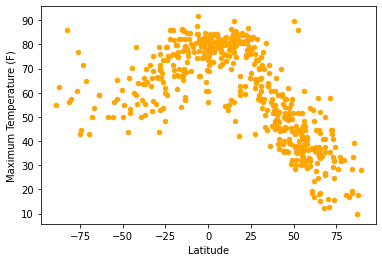

In [3]:
max_temp_plot = weather_batch_all.plot("latitude", "max_temp", 
                       kind = "scatter", 
                       color = "orange")

max_temp_plot.set_xlabel("Latitude")
max_temp_plot.set_ylabel("Maximum Temperature (F)")
plt.savefig("Images/maxtemp_all.png")
plt.show()

This scatter plot shows the relationship between maximum temperature and latitude.

* Note that the relationship is nonlinear because temperature increases when moving from the poles to the equator. 

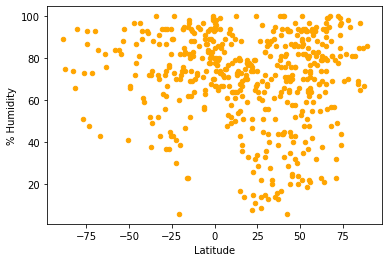

In [4]:
humidity_plot = weather_batch_all.plot("latitude", "humidity", 
                       kind = "scatter", 
                       color = "orange")

humidity_plot.set_xlabel("Latitude")
humidity_plot.set_ylabel("% Humidity")
plt.savefig("Images/humidity_all.png")
plt.show()

This scatter plot shows the relationship between latitude and percent humidity.

   * There is not a clear linear relationship between these variables.
   * Humidity does appear to be generally higher near the equator, as expected.


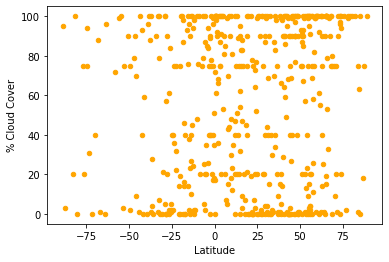

In [5]:
cloud_cover_plot = weather_batch_all.plot("latitude", "cloud_cover", 
                       kind = "scatter", 
                       color = "orange")

cloud_cover_plot.set_xlabel("Latitude")
cloud_cover_plot.set_ylabel("% Cloud Cover")
plt.savefig("Images/cloudcover_all.png")
plt.show()

This scatter plot shows the relationship between latitude and percent cloud cover.

   * There distribution here is multimodal, with bias towards 0 and 100% cloud cover.
   * There does not appear to be a clear linear relationship between these variables.

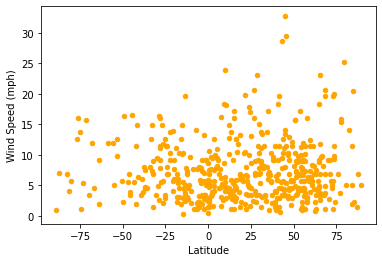

In [6]:
wind_speed_plot = weather_batch_all.plot("latitude", "wind_speed", 
                       kind = "scatter", 
                       color = "orange")

wind_speed_plot.set_xlabel("Latitude")
wind_speed_plot.set_ylabel("Wind Speed (mph)")
plt.savefig("Images/windspeed_all.png")
plt.show()

This scatter plot shows the relationship between latitude and wind speed.

   * The highest recorded wind speeds do appear to be in the northern hemisphere.
   * However there is substantial variance in wind speed at all latitudes.

In [7]:
northern_hem = weather_batch_all.loc[weather_batch_all["latitude"] > 0]
southern_hem = weather_batch_all.loc[weather_batch_all["latitude"] < 0]

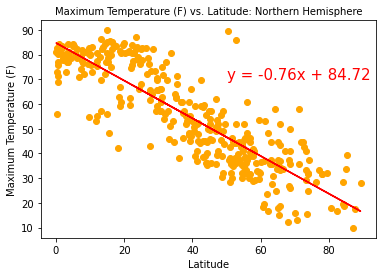

,Coefficient,Std_Error,P_value,R_squared
max_temp,-0.762784,0.024812,1.047405e-100,0.733143


In [8]:
# max_temp: northern hemisphere

x_values = northern_hem["latitude"]
y_values = northern_hem["max_temp"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature (F)")
plt.title("Maximum Temperature (F) vs. Latitude: Northern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (50, 70), fontsize = 15, color = "red")

plt.savefig("Images/maxtemp_north.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue], 
                                 "R_squared":[R2]}, index = ["max_temp"])

display(regression_table)

This scatter plot shows the relationship between latitude and maximum temperature in the Northern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * The linear regression indicates a significant decrease in average temperature with a one-degree increase in latitude.
       * Overall, a moderate to high proportion of the variance in temperature is explained by latitude (~ 73%).
       
   * The regression residuals appear to be correlated.
       * Observed temperatures were consistently higher than predicted near the equator and lower at intermediate 
         latitudes.  
       * The residuals are not normally distributed (see cell, below).
       * For these reasons, simple (OLS) regression may be inappropriate for these data.

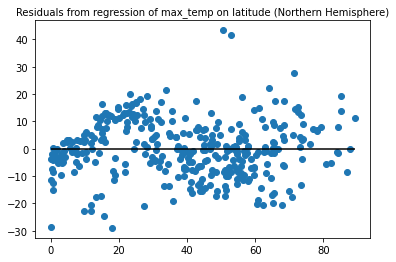

NormaltestResult(statistic=11.421556335706565, pvalue=0.003310095732343378)

In [9]:
# Pull out the residuals and plot them

# From above
x_values = northern_hem["latitude"]
y_values = northern_hem["max_temp"]
regress_values = (x_values * slope) + intercept

res_max_temp_NH = y_values - regress_values

plt.scatter(x_values, res_max_temp_NH)
plt.hlines(0, xmin = 0, xmax = max(x_values))
plt.title("Residuals from regression of max_temp on latitude (Northern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_max_temp_NH)

Reject null hypothesis that residuals are normally distributed!

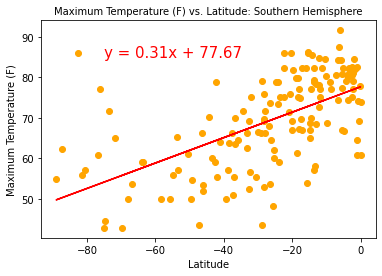

,Coefficient,Std_Error,P_value,R_squared
max_temp,0.314006,0.034255,3.193065e-16,0.356014


In [10]:
# max_temp: southern hemisphere

x_values = southern_hem["latitude"]
y_values = southern_hem["max_temp"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature (F)")
plt.title("Maximum Temperature (F) vs. Latitude: Southern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (-75, 85), fontsize = 15, color = "red")

plt.savefig("Images/maxtemp_south.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_squared":[R2]}, index = ["max_temp"])

display(regression_table)

This scatter plot shows the relationship between latitude and maximum temperature in the Southern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * The linear regression indicates a significant increase in average temperature with a one-degree increase in latitude.
       * Overall, 33% of the variance in temperature is explained by latitude.
           * This is substantially less than what was observed in the Northern Hemisphere.
           
   * The residuals appear to be correlated and the variance is heteroskedastic (i.e., not constant).
       * Variance in observed temperatures was highest near the South Pole and low nearer the Equator.
       * Temperatures were consistently lower than predicted at intermediate latitudes.
       * The residuals are not normally distributed (see cell, below).
       * For these reasons, simple (OLS) regression may be inappropriate for these data.

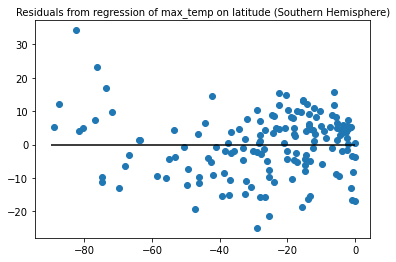

NormaltestResult(statistic=2.1272945680186366, pvalue=0.34519448918956414)

In [11]:
# Pull out the residuals and plot them

# From above
x_values = southern_hem["latitude"]
y_values = southern_hem["max_temp"]
regress_values = (x_values * slope) + intercept

res_max_temp_SH = y_values - regress_values

plt.scatter(x_values, res_max_temp_SH)
plt.hlines(0, xmin = -90, xmax = max(x_values))
plt.title("Residuals from regression of max_temp on latitude (Southern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_max_temp_SH)

Reject null hypothesis that residuals are normally distributed.

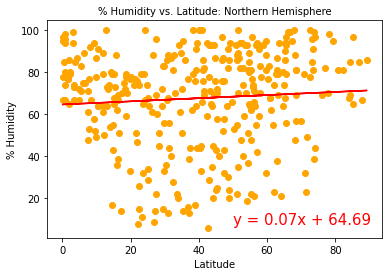

,Coefficient,Std_Error,P_value,R_squared
humidity,0.074754,0.055164,0.176272,0.00531


In [25]:
# humidity: northern hemisphere

x_values = northern_hem["latitude"]
y_values = northern_hem["humidity"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("% Humidity")
plt.title("% Humidity vs. Latitude: Northern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (50, 8), fontsize = 15, color = "red")

plt.savefig("Images/humdity_north.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_squared":[R2]}, index = ["humidity"])

display(regression_table)

This scatter plot shows the relationship between latitude and percent humidity in the Northern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * Only 0.5% of the variance in percent humidity is explained by latitude in the Northern Hemisphere.
   * Nevertheless:
       * Many of the observed data points are concentrated at high humidities, especially near the North Pole and Equator.
           * Model residuals appear to be correlated and left skewed.
       * The residuals are not normally distributed (see cell, below).
       * Percentage is also an inappropriate response variable for an OLS regression.
           * The preferred method is called "Beta Regression."
       * For these reasons, simple OLS regression is inappropriate for these data.

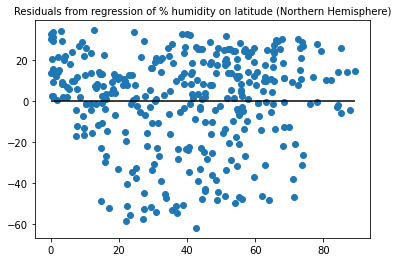

NormaltestResult(statistic=31.259704447321596, pvalue=1.6294514546624617e-07)

In [26]:
# Pull out the residuals and plot them

# From above
x_values = northern_hem["latitude"]
y_values = northern_hem["humidity"]
regress_values = (x_values * slope) + intercept

res_humidity_NH = y_values - regress_values

plt.scatter(x_values, res_humidity_NH)
plt.hlines(0, xmin = 0, xmax = max(x_values))
plt.title("Residuals from regression of % humidity on latitude (Northern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_humidity_NH)

Reject null hypothesis that residuals are normally distributed.

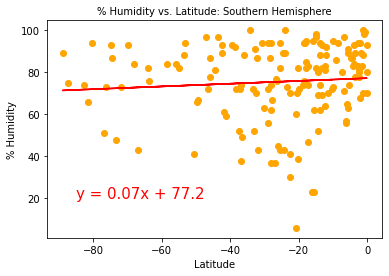

,Coefficient,Std_Error,P_value,R_squared
humidity,0.065398,0.067702,0.335596,0.006101


In [27]:
# humidity: southern hemisphere

x_values = southern_hem["latitude"]
y_values = southern_hem["humidity"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("% Humidity")
plt.title("% Humidity vs. Latitude: Southern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (-85, 20), fontsize = 15, color = "red")

plt.savefig("Images/humdity_south.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_squared":[R2]}, index = ["humidity"])

display(regression_table)

This scatter plot shows the relationship between latitude and percent humidity in the Southern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * Only 0.6% of the variance in percent humidity is explained by latitude in the Northern Hemisphere.
   * Nevertheless:
       * Many of the observed data points are concentrated at high humidities, especially near the Equator.
           * Compared to the Northern Hemisphere, where humidity was highest both near the Equator and North Pole.
       * The variance is heteroskedastic; varicne is generally lower near the equator.
       * The residuals are not normally distributed (see cell, below).
       * Percentage is an inappropriate response variable for a simple regression model.
           * The preferred method is called "Beta Regression."
       * For these reasons, simple (OLS) regression is likely inapproriate for these data.

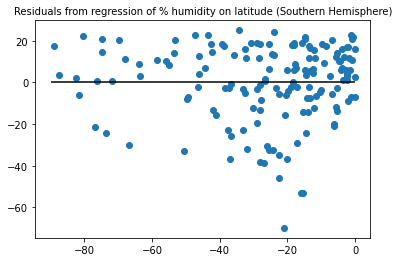

NormaltestResult(statistic=28.579411028074986, pvalue=6.223859028274945e-07)

In [28]:
# Pull out the residuals and plot them

# From above
x_values = southern_hem["latitude"]
y_values = southern_hem["humidity"]
regress_values = (x_values * slope) + intercept

res_humidity_SH = y_values - regress_values

plt.scatter(x_values, res_humidity_SH)
plt.hlines(0, xmin = -90, xmax = max(x_values))
plt.title("Residuals from regression of % humidity on latitude (Southern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_humidity_SH)

Reject the null hypothesis that the residuals are normally distributed.

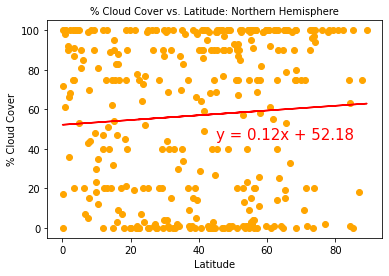

,Coefficient,Std_Error,P_value,R_value
cloud_cover,0.120191,0.0952,0.207623,0.004612


In [16]:
# cloud_cover: northern hemisphere

x_values = northern_hem["latitude"]
y_values = northern_hem["cloud_cover"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("% Cloud Cover")
plt.title("% Cloud Cover vs. Latitude: Northern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (45, 45), fontsize = 15, color = "red")

plt.savefig("Images/cloudcover_north.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_value":[R2]}, index = ["cloud_cover"])

display(regression_table)

This scatter plot shows the relationship between latitude and percent cloud cover in the Southern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * Only 0.4% of the variance in percent cloud cover is explained by latitude.
   * Values tend to be concentrated at 0 (sunny) and 100% (cloudy).
   * The residuals are not normally distributed (see cell, below).
   * Percentage is an inappropriate response for an OLS regression.
       * The preferred method is called "Beta Regression."
   * For these reasons, simple (OLS) regression may be inappropriate for these data.

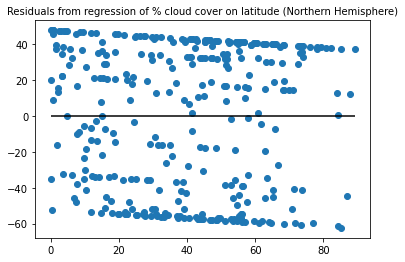

NormaltestResult(statistic=2828.928291352352, pvalue=0.0)

In [17]:
# Pull out the residuals and plot them

# From above
x_values = northern_hem["latitude"]
y_values = northern_hem["cloud_cover"]
regress_values = (x_values * slope) + intercept

res_cloudcover_NH = y_values - regress_values

plt.scatter(x_values, res_cloudcover_NH)
plt.hlines(0, xmin = 0, xmax = max(x_values))
plt.title("Residuals from regression of % cloud cover on latitude (Northern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_cloudcover_NH)

Reject the null hypothesis that the residuals are normally distributed.

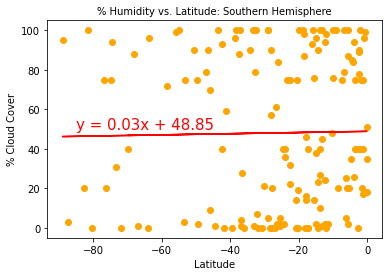

,Coefficient,Std_Error,P_value,R_value
cloud_cover,0.029631,0.14393,0.83717,0.000279


In [18]:
# cloud_cover: southern hemisphere

x_values = southern_hem["latitude"]
y_values = southern_hem["cloud_cover"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("% Cloud Cover")
plt.title("% Humidity vs. Latitude: Southern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (-85, 50), fontsize = 15, color = "red")

plt.savefig("Images/cloudcover_south.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_value":[R2]}, index = ["cloud_cover"])

display(regression_table)

This scatter plot shows the relationship between latitude and percent cloud cover in the Southern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * Only 0.02% of the variance in percent cloud cover is explained by latitude.
   * Values tend to be concentrated at 0 (sunny) and 100% (cloudy).
       * This plot also clearly shows the lower sample size at the lowest latitudes in the Southern Hemisphere.
   * The residuals are not normally distributed (see cell, below).
   * Percentage is an inappropriate response for an OLS regression.
       * The preferred method is called "Beta Regression."
   * For these reasons, simple (OLS) regression may be inappropriate for these data.

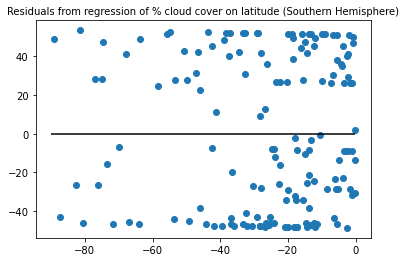

NormaltestResult(statistic=1726.1236210782906, pvalue=0.0)

In [19]:
# Pull out the residuals and plot them

# From above
x_values = southern_hem["latitude"]
y_values = southern_hem["cloud_cover"]
regress_values = (x_values * slope) + intercept

res_cloudcover_SH = y_values - regress_values

plt.scatter(x_values, res_cloudcover_SH)
plt.hlines(0, xmin = -90, xmax = max(x_values))
plt.title("Residuals from regression of % cloud cover on latitude (Southern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_cloudcover_SH)

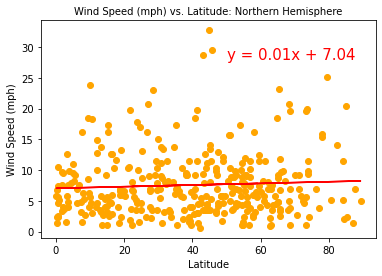

,Coefficient,Std_Error,P_value,R_squared
wind_speed,0.013346,0.01248,0.285619,0.003314


In [20]:
# wind speed: northern hemisphere

x_values = northern_hem["latitude"]
y_values = northern_hem["wind_speed"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) vs. Latitude: Northern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (50, 28), fontsize = 15, color = "red")

plt.savefig("Images/windspeed_north.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_squared":[R2]}, index = ["wind_speed"])

display(regression_table)

This scatter plot shows the relationship between latitude and wind speed in the Northern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * Only 0.3% of the variance in percent wind speed is explained by latitude.
   * Wind speeds were consistently lower than expected across most latitudes.
       * The highest wind speeds were found at intermediate latitudes.
       * Variance in temperature is right skewed.
       * The residuals are not normally distributed (see cell, below).
       * For these reasons, simple (OLS) regression may be inappropriate for these data.

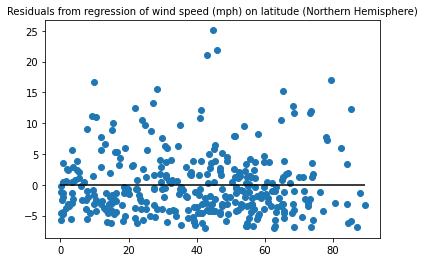

NormaltestResult(statistic=107.22317452447551, pvalue=5.20934938380701e-24)

In [21]:
# Pull out the residuals and plot them

# From above
x_values = northern_hem["latitude"]
y_values = northern_hem["wind_speed"]
regress_values = (x_values * slope) + intercept

res_windspeed_NH = y_values - regress_values

plt.scatter(x_values, res_windspeed_NH)
plt.hlines(0, xmin = 0, xmax = max(x_values))
plt.title("Residuals from regression of wind speed (mph) on latitude (Northern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_windspeed_NH)

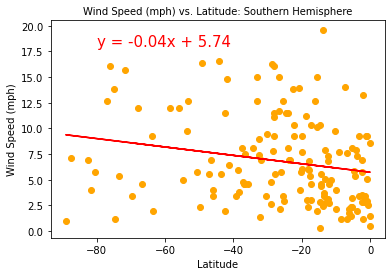

,Coefficient,Std_Error,P_value,R_squared
wind_speed,-0.040972,0.015443,0.008823,0.044259


In [22]:
# wind speed: southern hemisphere

x_values = southern_hem["latitude"]
y_values = southern_hem["wind_speed"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_values, y_values, color = "orange")
plt.plot(x_values, regress_values, color = "red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed (mph) vs. Latitude: Southern Hemisphere", fontsize = 10)
plt.annotate(line_eq, (-80, 18), fontsize = 15, color = "red")

plt.savefig("Images/windspeed_south.png")
plt.show()

R2 = rvalue**2
regression_table = pd.DataFrame({"Coefficient":[slope], 
                                 "Std_Error":[stderr], 
                                 "P_value":[pvalue],
                                 "R_squared":[R2]}, index = ["wind_speed"])

display(regression_table)

This scatter plot shows the relationship between latitude and wind speed in the Southern Hemisphere.

A linear regression model (with fit line) have been superimposed on the scatter plot.

   * 4.4% of the variance in percent wind speed was explained by latitude, which is low, but higher than in the Northern 
     Hemisphere.
   * Interestingly, the overall pattern appears slightly different than in the Northern Latitude.
       * This could partly be due to lower sample size. 
   * Variance in wind speed appears to decrease as you approach the Equator.
   * The residuals are not normally distributed (see cell, below).
   * For these reasons, simple (OLS) regression may be inappropriate for these data.

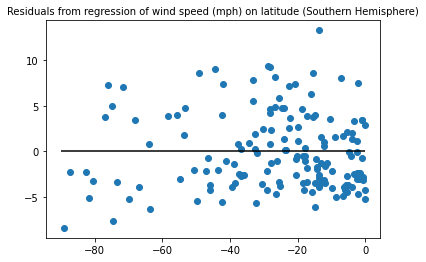

NormaltestResult(statistic=10.259367231564443, pvalue=0.005918432676191306)

In [23]:
# Pull out the residuals and plot them

# From above
x_values = southern_hem["latitude"]
y_values = southern_hem["wind_speed"]
regress_values = (x_values * slope) + intercept

res_windspeed_SH = y_values - regress_values

plt.scatter(x_values, res_windspeed_SH)
plt.hlines(0, xmin = -90, xmax = max(x_values))
plt.title("Residuals from regression of wind speed (mph) on latitude (Southern Hemisphere)", fontsize = 10)
plt.show()

st.normaltest(res_windspeed_SH)